In [7]:
from fairseq import checkpoint_utils
import torch
hubert,_,_ = checkpoint_utils.load_model_ensemble_and_task(
    ["../assets/hubert/hubert_base.pt"],
    suffix="",
)
hubert_model = hubert[0]
hubert_model = hubert_model.half()
hubert_model.eval()

# Create a Adapter model
class HuberAdapter(torch.nn.Module):
    def __init__(self, model):
        super(HuberAdapter, self).__init__()
        self.model = model
    def forward(self,feats):
        # inputs = {
        #     "source": feats,
        #     "padding_mask": padding_mask,
        #     # "padding_mask": None,
        #     "output_layer": 12
        # }
        # return self.model.extract_features(**inputs)
        return self.model(
            source = feats,
            output_layer = 12,
            features_only = True,
            mask = False
        )['x']

# Loading presaved feats and padding mask
feats = torch.load("./feats.pt")
padding_mask = torch.load("./padding_mask.pt")

/home/elin/anaconda3/envs/rvc/lib/python3.10/site-packages/fairseq/checkpoint_utils.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, map_location=

In [10]:
feats.shape

torch.Size([1, 32160])

In [11]:
adapter = HuberAdapter(hubert_model.cuda())

In [12]:
output = adapter(feats)

In [13]:
output[0].shape

torch.Size([100, 768])

In [14]:
output[0]

tensor([[-0.1176, -0.0119, -0.1047,  ..., -0.0266,  0.1201, -0.0277],
        [-0.2391, -0.1185, -0.3022,  ..., -0.2744,  0.0822,  0.1036],
        [-0.1465, -0.0118, -0.2264,  ..., -0.2832, -0.0356,  0.0518],
        ...,
        [-0.0827,  0.2035, -0.3237,  ..., -0.0261,  0.3257,  0.0415],
        [-0.1318,  0.2222, -0.0958,  ...,  0.1375,  0.3198,  0.1580],
        [ 0.0555,  0.0272, -0.1810,  ..., -0.0231, -0.0336, -0.1392]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)

In [9]:
!pip install onnx onnxruntime-gpu

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
  Using cached https://repo.huaweicloud.com/repository/pypi/packages/dd/5b/c4f95dbe652d14aeba9afaceb177e9ffc48ac3c03048dd3f872f26f07e34/onnx-1.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 9.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 33.1 MB/s eta 0:00:00


Before runnning exportation code,i;ve modified fairseq/models/wav2vec/utils.py with below code:
```python
def pad_to_multiple(x, multiple, dim=-1, value=0):
    # Inspired from https://github.com/lucidrains/local-attention/blob/master/local_attention/local_attention.py#L41
    if x is None:
        return None, 0
    tsz = x.size(dim)
    m = tsz / multiple
    remainder = math.ceil(m) * multiple - tsz
    m = float(m) # => If without this,will raise `Tensor object has no attribute is_integer()`
    if m.is_integer():
        return x, 0
    pad_offset = (0,) * (-1 - dim) * 2

    return F.pad(x, (*pad_offset, 0, remainder), value=value), remainder
```

In [15]:
torch.onnx.export(
    adapter.cuda(),
    (feats.cuda()),
    "hubert.onnx",
    input_names=["feats",],
    output_names=["logits",],
    dynamic_axes={
        "feats": {0: "batch", 1: "seq"},
        "logits": {0: "batch", 1: "seq"},
    },
    opset_version=14,
    do_constant_folding=True,
)

/home/elin/anaconda3/envs/rvc/lib/python3.10/site-packages/fairseq/models/wav2vec/utils.py:16: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  remainder = math.ceil(m) * multiple - tsz
/home/elin/anaconda3/envs/rvc/lib/python3.10/site-packages/fairseq/models/wav2vec/utils.py:17: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  m = float(m)
/home/elin/anaconda3/envs/rvc/lib/python3.10/site-packages/fairseq/modules/multihead_attention.py:506: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flo

In [16]:
# 读取ONNX
import onnxruntime as ort

model = ort.InferenceSession("./ONNX_Models/hubert.onnx",providers = ["CUDAExecutionProvider"])

model

2025-02-20 22:34:29.633033374 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 12 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2025-02-20 22:34:29.638827820 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-02-20 22:34:29.638843880 [W:onnxruntime:, session_state.cc:1170 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [17]:
r = model.run(
    ["logits",],
    {
        "feats": feats.cpu().numpy(),
        # "padding_mask": padding_mask.cpu().numpy()
    }
)[0]

In [18]:
import numpy as np

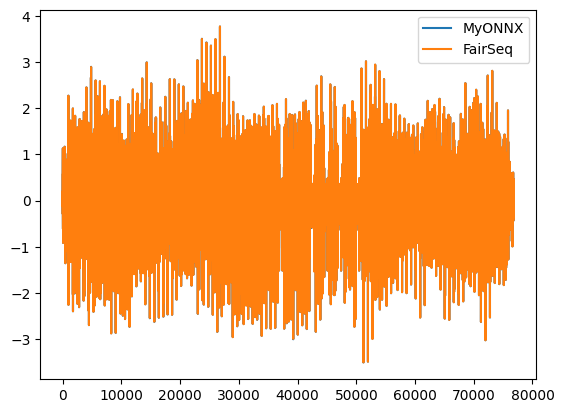

In [19]:
import matplotlib.pyplot as plt
plt.plot(np.array(r.flatten()),label="MyONNX")
plt.plot(output[0].flatten().cpu().detach().numpy(),label="FairSeq")
plt.legend()
plt.savefig("./output.png",dpi=300)
plt.show()